## Natural Language Processing with Disaster Tweets

### Approach: Multinomial Naive Bayes + TF-IDF

---
### Data Analysis

- Dataset size: 
    - training: 7503 unique values
    - testing: 3263 unique values
- Problem Nature:
    - Tweets are short: 280 characters max.
    - Vocabulary can be noisy: hashtags, misspellings, slang, abbreviations.  
    - Contextual clues matter: tweets could be sarcastic/humorous.


---
#### Dependencies

In [1]:
# pip install pandas numpy scikit-learn nltk ftfy matplotlib html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Pre-processing

In [2]:
import re
import html
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.stem import PorterStemmer
from ftfy import fix_text
# from emoji import demojize

# nltk.download('stopwords')
# nltk.download('wordnet')

# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
# stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Fix broken unicode errors (e.g. "Û÷Institute" and "PeaceÛª")
    text = fix_text(text)

    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Decode HTML entities (e.g. &amp;)
    text = html.unescape(text)

    # REDUCES ACCURACY
    # # demojize emojis :emoji_face:
    # text = demojize(text)
    #text = re.sub(r'[^a-zA-Z\s:]', '', text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text) 

    # Convert to lowercase
    text = text.lower()

    # REDUCES ACCURACY (likely doesn't play well with TF-IDF)
    # # Remove stop words 
    # text = ' '.join(word for word in text.split() if word not in stop_words)

    # # Apply stemming
    # text = ' '.join(stemmer.stem(word) for word in text.split())

    # # Apply lemmatization
    # text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    # Replace multiple spaces/tabs/newlines with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_data(df):
    # Fill missing values in 'keyword' and 'location' columns with empty strings
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)

    # Combine [text, keyword, location] columns into [combined_text] column
    df['combined_text'] = df['text'] + " " + df['keyword'] + " " + df['location']
    
    # Clean the combined text
    df['combined_text'] = df['combined_text'].apply(clean_text)
    
    # Create a new feature 'text_length' to store the length of the original 'text' column
    df['text_length'] = df['text'].apply(len)
    
    # Return the modified DataFrame
    return df

#### Processing

In [9]:
# Load the datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [10]:
# Preview of cleaned tweets from the training dataset
sample_tweets = train_df.sample(4)
for _, tweet in sample_tweets.iterrows():
    original = tweet['text']
    cleaned = clean_text(original)
    
    print(f"Original: {original}")
    print(f"Cleaned:  {cleaned}")
    print("-" * 80)

Original: Devil May Cry 4 Special Edition Vergil Vs Agnus [Window] Mission 6 - DMD - No Damage By LeedStraiF
https://t.co/ZhRTcVU0Ff
Cleaned:  devil may cry special edition vergil vs agnus window mission dmd no damage by leedstraif
--------------------------------------------------------------------------------
Original: New illustration for the L.A. Times: http://t.co/qYn6KxJSTl #illustration #subway
Cleaned:  new illustration for the la times illustration subway
--------------------------------------------------------------------------------
Original: A Time-Lapse Map of Every Nuclear Explosion Since 1945 - by Isao Hashimoto #War #atomicbomb 
https://t.co/V0t8H4Iecc
Cleaned:  a timelapse map of every nuclear explosion since by isao hashimoto war atomicbomb
--------------------------------------------------------------------------------
Original: @VileLunar I trickshot with a regular controller fucking infinite fading is so harm &gt;:(
Cleaned:  vilelunar i trickshot with a regular co

---

#### Processing

In [11]:
# Preprocess the data
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Features and labels
y = train_df['target']

# Text vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    stop_words='english',
    max_features=10000
)

# Vectorize the training data
X_text = vectorizer.fit_transform(train_df['combined_text'])

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

# perform grid search for best alpha
param_grid = {'alpha': [0.1, 0.3, 0.5, 1.0, 2.0]}
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Final model
model = MultinomialNB(alpha=best_alpha)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# (https://medium.com/hugo-ferreiras-blog/confusion-matrix-and-other-metrics-in-machine-learning-894688cb1c0a)
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val,  y_pred))

Best alpha: 0.5
Validation Accuracy: 0.8174655285620486
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Confusion Matrix:
 [[792  77]
 [201 453]]


#### Feature Importance Extraction: Top positive and negative words

Top Positive Words:
debris: 3.4482
derailment: 3.2949
outbreak: 3.2571
hiroshima: 3.2408
bomber: 3.0411
suicide bomber: 3.0264
legionnaires: 2.9607
wreckage: 2.9533
severe: 2.9427
spill: 2.8415

Top Negative Words:
aftershock: -3.1538
wrecked: -2.7715
ruin: -2.7182
electrocute: -2.6890
stretcher: -2.6757
harm: -2.4753
bags: -2.4197
bodybags: -2.4054
blazing: -2.4044
blizzard: -2.3612


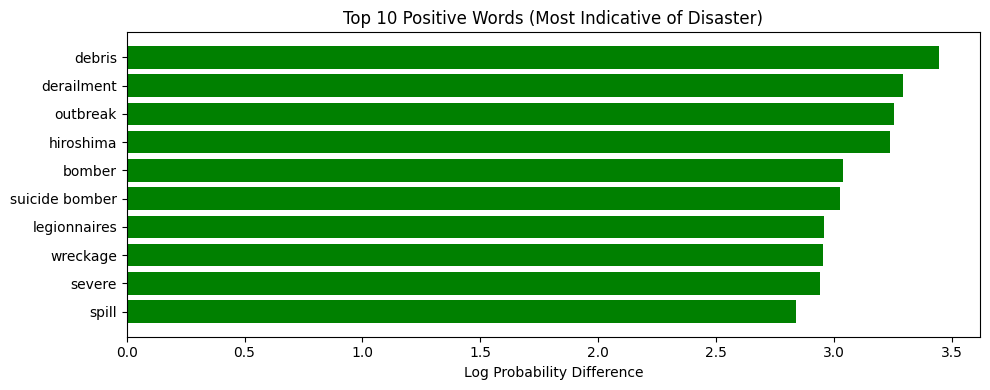

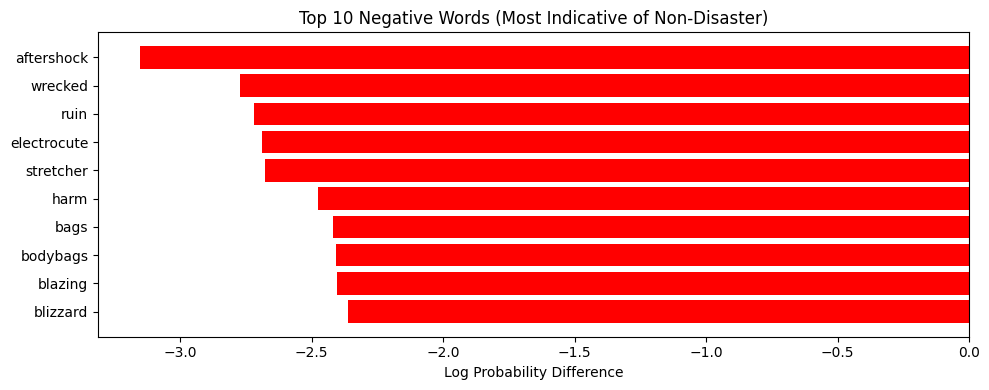

In [12]:
import matplotlib.pyplot as plt

# Extract feature names from the vectorizer (https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities for each class
log_probabilities = model.feature_log_prob_

# Calculate the difference between the log probabilities of the two classes
coefficients = log_probabilities[1] - log_probabilities[0]

# Get top positive and negative words
top_positive_idx = np.argsort(coefficients)[-10:][::-1]
top_negative_idx = np.argsort(coefficients)[:10]

top_positive_words = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

# unpack
positive_words, positive_scores = zip(*top_positive_words)
negative_words, negative_scores = zip(*top_negative_words)

print("Top Positive Words:")
for word, score in top_positive_words:
    print(f"{word}: {score:.4f}")

print("\nTop Negative Words:")
for word, score in top_negative_words:
    print(f"{word}: {score:.4f}")

# Plot top positive words
plt.figure(figsize=(10, 4))
plt.barh(positive_words[::-1], positive_scores[::-1], color='green')
plt.title('Top 10 Positive Words (Most Indicative of Disaster)')
plt.xlabel('Log Probability Difference')
plt.tight_layout()
plt.show()

# Plot top negative words
plt.figure(figsize=(10, 4))
plt.barh(negative_words[::-1], negative_scores[::-1], color='red')
plt.title('Top 10 Negative Words (Most Indicative of Non-Disaster)')
plt.xlabel('Log Probability Difference')
plt.tight_layout()
plt.show()

---
#### Submission

In [13]:
# vectize test data
X_test_text = vectorizer.transform(test_df['combined_text'])

# Predict and save
test_predictions = model.predict(X_test_text)

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": test_predictions
})

file_name = "../results/ap_1.csv"
submission.to_csv(file_name, index=False)
print(f"Submission saved as {file_name}")

Submission saved as ../results/ap_1.csv
